In [69]:
#%pip install yfinance

In [149]:
import yfinance as yf
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from scipy.stats import norm
import math

import matplotlib.pyplot as plt

In [71]:
# Chargement de l'historique des actifs sur les deux dernières années
end_date = datetime.now()
strat_date = end_date - timedelta(days=2*365)
tickers = ['SAN.PA', 'BN.PA',  'AIR.PA', 'AI.PA', 'ORA.PA', 'CAP.PA', 'VIV.PA', 'CA.PA', 'ENGI.PA', 'DG.PA']
df = yf.download(tickers, start = strat_date, end=end_date)[['Close', 'Volume']]

cac40 = yf.download('^FCHI', start = strat_date, end=end_date)[['Close', 'Volume']]

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [72]:
df.head()

Price            Close                                                \
Ticker           AI.PA      AIR.PA      BN.PA      CA.PA      CAP.PA   
Date                                                                   
2023-01-30  129.703018  113.202339  46.732342  16.069134  166.543777   
2023-01-31  128.141388  112.535980  46.928230  16.005003  167.555466   
2023-02-01  127.790466  113.711906  47.292011  15.972937  170.349670   
2023-02-02  128.702866  115.397400  47.124111  16.078293  181.478287   
2023-02-03  127.492165  114.770241  47.329327  15.995840  182.104553   

Price                                                             Volume  \
Ticker          DG.PA    ENGI.PA    ORA.PA     SAN.PA    VIV.PA    AI.PA   
Date                                                                       
2023-01-30  96.130051  10.756801  8.415674  83.109283  9.450281   922207   
2023-01-31  95.871048  10.796604  8.508444  82.998215  9.362902   982086   
2023-02-01  96.870094  10.906063  8.504066  82.100380  9.395194   498535   
2023-02-02  97.166107  10.707047  8.443680  80.313980  9.469277   935729   
2023-02-03  97.443611  10.859626  8.393794  78.805260  9.402792  1217643   

Price                                                                     \
Ticker       AIR.PA    BN.PA    CA.PA  CAP.PA    DG.PA  ENGI.PA   ORA.PA   
Date                                                                       
2023-01-30  1080203  1318109  1503551  265113   832568  3784922  5398200   
2023-01-31  1357678  1195913  1947261  472465   850875  5761592  7767232   
2023-02-01  1102143  1111493  1091097  272322   907425  5894306  4980785   
2023-02-02  1394176  2013542  1805955  568976   920499  7742563  7100632   
2023-02-03  1587465  1649190  1730754  383622  1106022  5942379  7368347   

Price                         
Ticker       SAN.PA   VIV.PA  
Date                          
2023-01-30  1235322  2938565  
2023-01-31  2218706  2470382  
2023-02-01  1614583  2025489  
2023-02-02  2421074  2434350  
2023-02-03  4394526  2855250

In [73]:
df_close = df['Close']
df_volume = df['Volume']

In [74]:
# Poids des actions dans le portefeuille
weights = np.repeat(0.1, 10)

weights = pd.DataFrame({'Ticker': ['SAN.PA', 'BN.PA',  'AIR.PA', 'AI.PA', 'ORA.PA', 'CAP.PA', 'VIV.PA', 'CA.PA', 'ENGI.PA', 'DG.PA'],
                        'Weight': weights})
weights = weights.set_index('Ticker')['Weight']

print(weights)

Ticker
SAN.PA     0.1
BN.PA      0.1
AIR.PA     0.1
AI.PA      0.1
ORA.PA     0.1
CAP.PA     0.1
VIV.PA     0.1
CA.PA      0.1
ENGI.PA    0.1
DG.PA      0.1
Name: Weight, dtype: float64


In [75]:
# Détermination de l'AUM
aum = df_close@weights
portfolio = pd.DataFrame({'AUM': aum})
portfolio.head()

,AUM
Date,
2023-01-30,68.011270
2023-01-31,67.870328
2023-02-01,68.289279
2023-02-02,69.488105
2023-02-03,69.259721


In [76]:
# Performance du portefeuille
portfolio['perf'] = portfolio['AUM'].pct_change()
portfolio.dropna(inplace=True)


In [77]:
portfolio.head()

,AUM,perf
Date,,
2023-01-31,67.870328,-0.002072
2023-02-01,68.289279,0.006173
2023-02-02,69.488105,0.017555
2023-02-03,69.259721,-0.003287
2023-02-06,68.508216,-0.010851


# Volatiliy

In [78]:
# Volatilité annualisé du portefeuille
std_dev = portfolio.std()*np.sqrt(252)
std_dev

AUM     74.064066
perf     0.127604
dtype: float64

In [79]:
# Performance du benchmark
cac40_df = cac40['Close']
cac40_df ['perf'] = cac40_df.pct_change()
cac40_df.dropna(inplace=True)


In [80]:
# Volatilité du benchmark
cac40_df.std()*np.sqrt(252)

Ticker
^FCHI    4952.982724
perf        0.133702
dtype: float64

# Tracking error

In [81]:
# Tracking error
portfolio['benchmark'] = cac40_df['perf']
portfolio['tracking_error'] = portfolio['perf'] - portfolio['benchmark']
TError = portfolio['tracking_error'].std()*np.sqrt(252) # Annualisation

TError

0.07697383277871685

# Value at risk

## VaR historique

In [82]:
VaR = portfolio.quantile(1-0.99)*np.sqrt(20) # 1-day VaR skaled to 20-day VaR
print(VaR)

AUM               305.467478
perf               -0.102666
benchmark          -0.095200
tracking_error     -0.056828
Name: 0.010000000000000009, dtype: float64


## VaR paramétrique

In [83]:
VaR = (portfolio.mean() + norm.ppf(1-0.99)*portfolio.std())*np.sqrt(20)
print(VaR)

AUM               296.047495
perf               -0.081950
benchmark          -0.086496
tracking_error     -0.049897
dtype: float64


# Stress test

In [84]:
# Données des actions en période covid
stress_date_1 = "2020-02-19"
stress_date_2 = "2020-03-19"

tickers = ['SAN.PA', 'BN.PA',  'AIR.PA', 'AI.PA', 'ORA.PA', 'CAP.PA', 'VIV.PA', 'CA.PA', 'ENGI.PA', 'DG.PA']
df_stress = yf.download(tickers, start = stress_date_1, end=stress_date_2)['Close']
cac40_stress = yf.download('^FCHI', start = stress_date_1, end=stress_date_2)['Close']

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [85]:
aum_stress = df_stress@weights
portfolio_stress = pd.DataFrame({'AUM': aum_stress})


In [86]:
# Rendement du portefeuille en période de covid
portfolio_stress.iloc[-1,] /portfolio_stress.iloc[0,]  - 1

AUM   -0.394026
dtype: float64

In [87]:
# Rendemnt du benchmark enn période covid
cac40_stress.iloc[-1,] / cac40_stress.iloc[0,] -1

Ticker
^FCHI   -0.385585
dtype: float64

# Profiles de liquidité du portefeuille

In [166]:
def liqudity(df_volume, ADV_rate = 0.2, weight_adjust = 1, label="Conditions normales avec déformation"):
    # Calcul de la moyenne mobile du volume (ADV) sur une fenêtre de 60 jours
    ADV = df_volume.rolling(window=60).mean()

    # Extraction de la dernière ligne (les valeurs ADV les plus récentes)
    latest_ADV = ADV.iloc[-1,]  # Cela donne l'ADV le plus récent pour tous les tickers

    # Création d'un DataFrame pour la liquidité du portefeuille
    portfolio_liquidity = pd.DataFrame({'Ticker': tickers, 'ADV': latest_ADV.values, 'Prix': df_close.iloc[-1,].values})

    # Définir 'Ticker' comme index pour un accès plus facile
    portfolio_liquidity = portfolio_liquidity.set_index('Ticker')

    # Calcul de la quantité (QUANTITE) basée sur le volume le plus récent
    np.random.seed(42)
    portfolio_liquidity["QUANTITE"] = weight_adjust*1.5*np.random.uniform(0,1,10)*portfolio_liquidity['ADV']

    # Calcul de la quantité liquidable (20 % de l'ADV)
    portfolio_liquidity['QUANTITE LIQUIDABLE'] = ADV_rate * portfolio_liquidity['ADV']

    # Calcul du nombre de jours de liquidation
    portfolio_liquidity['NB_JOURS DE LIQUIDATION'] = np.ceil(
        portfolio_liquidity['QUANTITE'] / portfolio_liquidity['QUANTITE LIQUIDABLE']
    )

    i = 1
    # Initialize the first day's liquidation (JOUR 1)

    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity['QUANTITE'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity[f'POIDS {0}']/portfolio_liquidity[f'POIDS {0}'].sum()


    portfolio_liquidity[f'JOUR {i}'] = portfolio_liquidity['QUANTITE'] - portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}']/portfolio_liquidity[f'POIDS {i}'].sum()

    # Continue calculating for subsequent days while there is quantity remaining
    while portfolio_liquidity[f'JOUR {i}'].max() > 0:
        i += 1
        portfolio_liquidity[f'JOUR {i}'] = (
            (portfolio_liquidity[f'JOUR {i-1}'] - portfolio_liquidity[f'JOUR {i-1}'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
    )
            .clip(lower=0)
        )
        # Mise à jour des poids
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}']/portfolio_liquidity[f'POIDS {i}'].sum()
        
    return portfolio_liquidity


In [243]:
def liquidity_profile(portfolio_liquidity, label="Profil de liquidité en conditions normales avec déformation"):
    # Calculer le profil de liquidité
    liquidity_profile = [portfolio_liquidity['QUANTITE']]
    for i in range(1, int(portfolio_liquidity['NB_JOURS DE LIQUIDATION'].max()) + 1):
        liquidity_profile.append(portfolio_liquidity[f'JOUR {i}'])

    liquidity_profile = pd.DataFrame(liquidity_profile)

    # Calculer le profil en pourcentage de liquidité restante
    profile = liquidity_profile @ portfolio_liquidity['Prix']
    
    portefeuille_valeur = profile['QUANTITE']  # Récupérer la valeur du portefeuille
    profile = 100 - profile[1:,] * 100 / portefeuille_valeur

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Une ligne, deux colonnes

    # Premier graphique : Profil de liquidité (courbe + barres)
    ax1 = axes[0]
    profile.plot(ax=ax1, marker='o', legend=False, color='blue')
    barplot = profile.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black', alpha=0.5)

    # Ajouter les valeurs arrondies au centième sur les barres
    for bar in barplot.patches:
        value = round(bar.get_height(), 2)  # Arrondir au centième
        ax1.text(bar.get_x() + bar.get_width() / 2,  # Position horizontale
                bar.get_height() + 0.5,  # Position verticale (au-dessus de la barre)
                f"{value}",  # Texte affiché
                ha='center', va='bottom', fontsize=10, color='black')

    ax1.set_title(f"{label}", fontsize=14)
    ax1.set_xlabel("Jours", fontsize=12)
    ax1.set_ylabel("Liquidité du portefeuille (%)", fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajouter une étiquette avec la valeur du portefeuille
    ax1.text(0.95, 0.05, f"Valeur portefeuille : {round(portefeuille_valeur)} euros",
        transform=ax1.transAxes, fontsize=12, color='red', ha='right', va='bottom',
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="red"))



    # Deuxième graphique : Évolution des poids
    ax2 = axes[1]
    for i in range(int(portfolio_liquidity['NB_JOURS DE LIQUIDATION'].max()) + 1):
        if f'POIDS {i}' in portfolio_liquidity.columns:  # Vérifier l'existence de la colonne
            ax2.plot(portfolio_liquidity[f'POIDS {i}'], label=f'Jour {i}')
        else:
            print(f"Colonne 'POIDS {i}' non trouvée.")
    ax2.set_title("Évolution des Poids au Fil des Jours", fontsize=14)
    ax2.set_xlabel("Index", fontsize=12)
    ax2.set_ylabel("Poids", fontsize=12)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajuster l'espacement global
    plt.tight_layout()
    plt.show()


## Profile de liquidité en conditions normales avec déformation

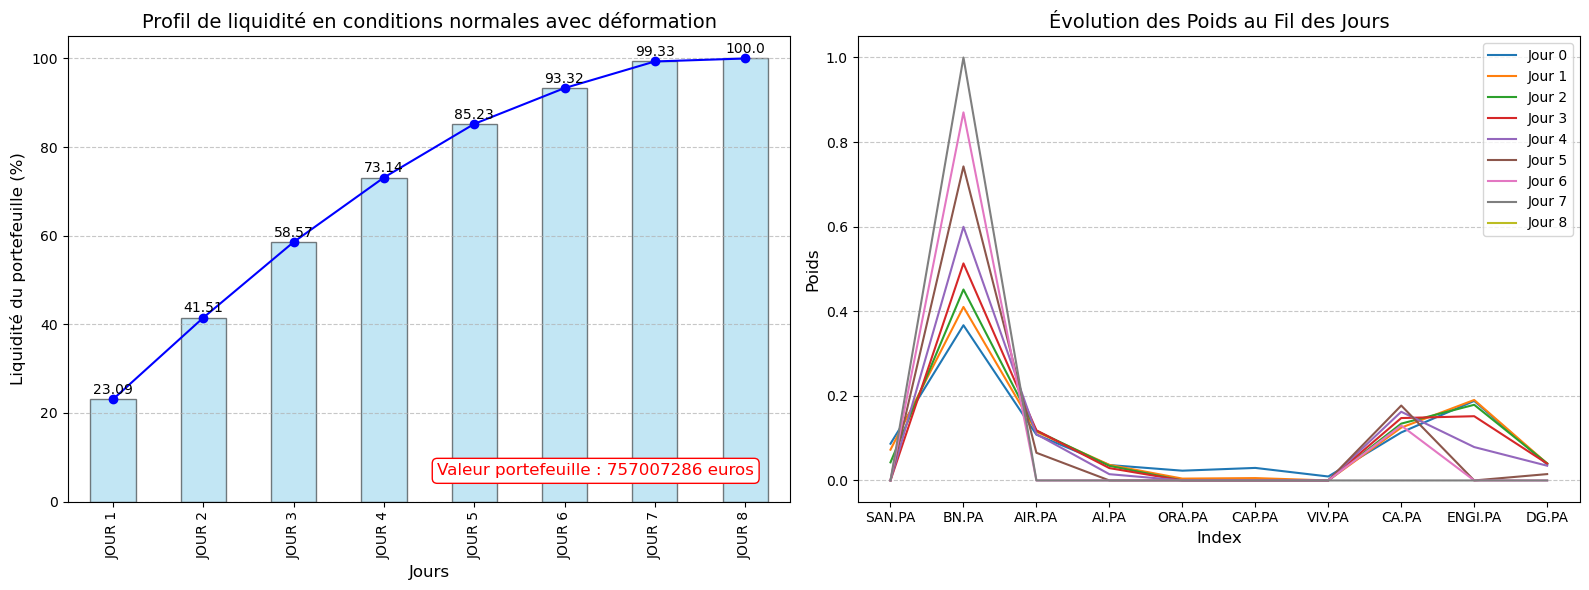

In [244]:
portfolio_liquidity = liqudity(df_volume)
liquidity_profile(portfolio_liquidity)

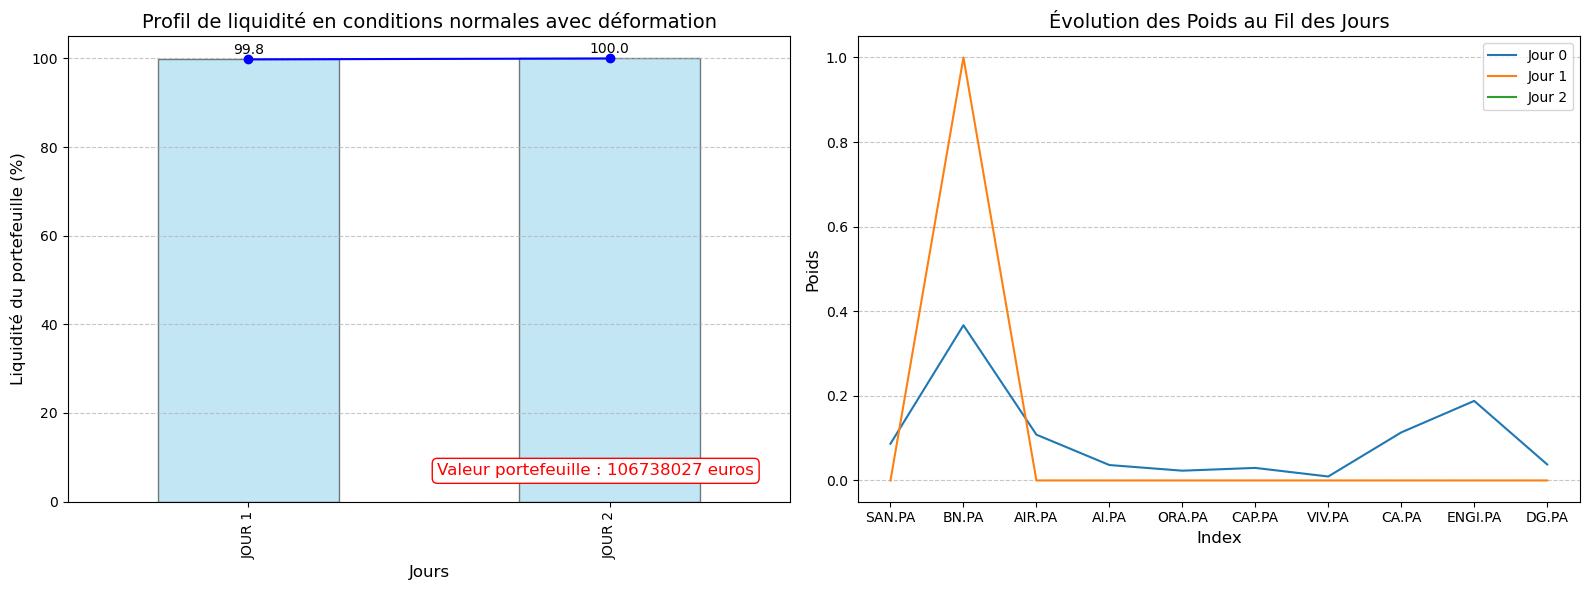

In [245]:
portfolio_liquidity = liqudity(df_volume, weight_adjust=0.141) # Taille optimale du portefeuille
liquidity_profile(portfolio_liquidity)

# Afficher la taille du portefeuille

## Profile de liquidité en conditions stressée avec déformation

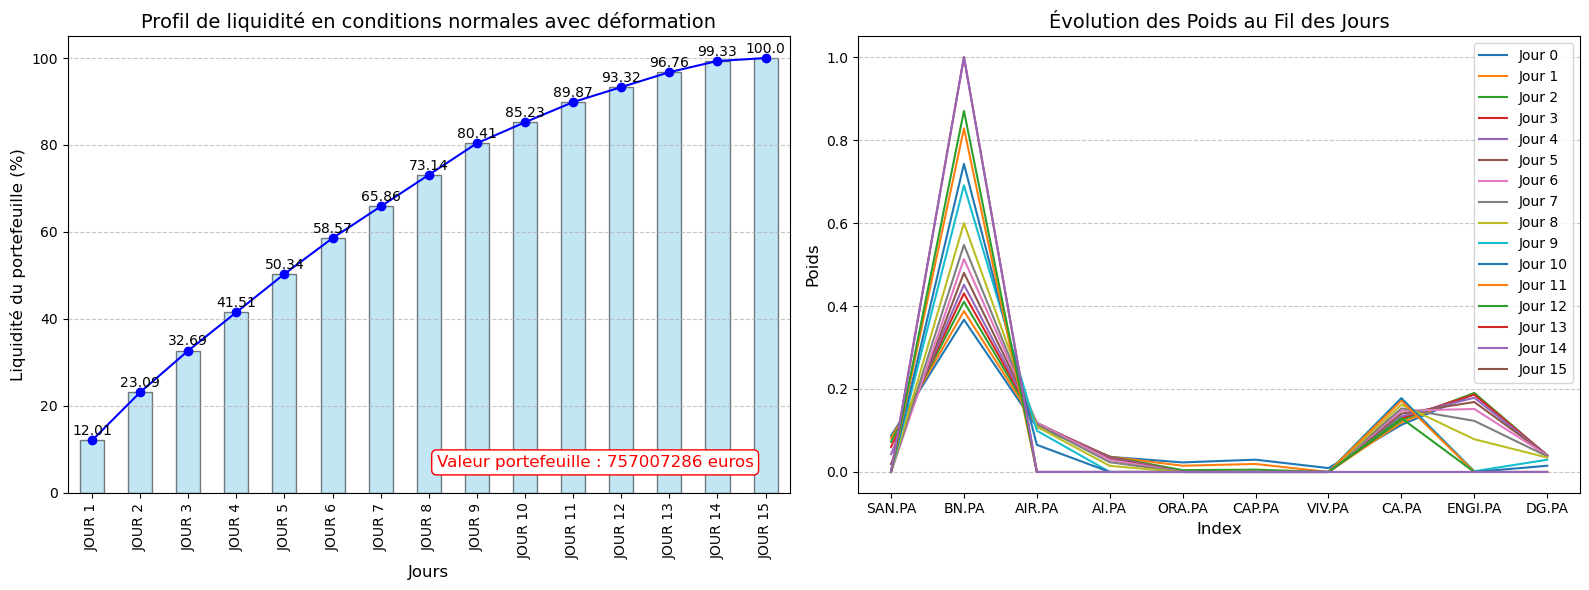

In [246]:
portfolio_liquidity = liqudity(df_volume, ADV_rate=0.1)
liquidity_profile(portfolio_liquidity)

## Profil d'écoulement sans déformation

In [247]:
def liqudity_proformat(df_volume, ADV_rate = 0.2, weight_adjust = 1):
    # Calcul de la moyenne mobile du volume (ADV) sur une fenêtre de 60 jours
    ADV = df_volume.rolling(window=60).mean()

    # Extraction de la dernière ligne (les valeurs ADV les plus récentes)
    latest_ADV = ADV.iloc[-1,]  # Cela donne l'ADV le plus récent pour tous les tickers

    # Création d'un DataFrame pour la liquidité du portefeuille
    portfolio_liquidity = pd.DataFrame({'Ticker': tickers, 'ADV': latest_ADV.values, 'Prix': df_close.iloc[-1,].values})

    # Définir 'Ticker' comme index pour un accès plus facile
    portfolio_liquidity = portfolio_liquidity.set_index('Ticker')

    # Calcul de la quantité (QUANTITE) basée sur le volume le plus récent
    np.random.seed(42)
    portfolio_liquidity["QUANTITE"] = weight_adjust*1.5*np.random.uniform(0,1,10)*portfolio_liquidity['ADV']

    # Calcul de la quantité liquidable (20 % de l'ADV)
    portfolio_liquidity['QUANTITE LIQUIDABLE'] = ADV_rate * portfolio_liquidity['ADV']

    # Calcul du nombre de jours de liquidation
    portfolio_liquidity['NB_JOURS DE LIQUIDATION'] = np.ceil(
        portfolio_liquidity['QUANTITE'] / portfolio_liquidity['QUANTITE LIQUIDABLE']
    )

    i = 1
    # Initialize the first day's liquidation (JOUR 1)

    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity['QUANTITE'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity[f'POIDS {0}']/portfolio_liquidity[f'POIDS {0}'].sum()
    
    portfolio_liquidity[f'JOUR {i}'] = portfolio_liquidity['QUANTITE'] - portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}']/portfolio_liquidity[f'POIDS {i}'].sum()
    
    portfolio_liquidity[f'SPEED {i}'] = portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE']) /  portfolio_liquidity['QUANTITE']

    # Continue calculating for subsequent days while there is quantity remaining
    while portfolio_liquidity[f'JOUR {i}'].max() > 0:
        i += 1
        portfolio_liquidity[f'JOUR {i}'] = (
            (portfolio_liquidity[f'JOUR {i-1}'] - portfolio_liquidity[f'JOUR {i-1}']*portfolio_liquidity[f'SPEED {i-1}'].min())
    ).clip(lower=0)
        
        # Mise à jour des poids
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}']/portfolio_liquidity[f'POIDS {i}'].sum()
        
        portfolio_liquidity[f'SPEED {i}'] = portfolio_liquidity[f'JOUR {i}'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE']) /  portfolio_liquidity[f'JOUR {i}']
        
    return portfolio_liquidity


## Profil de liquidité en conditions normales sans déformation

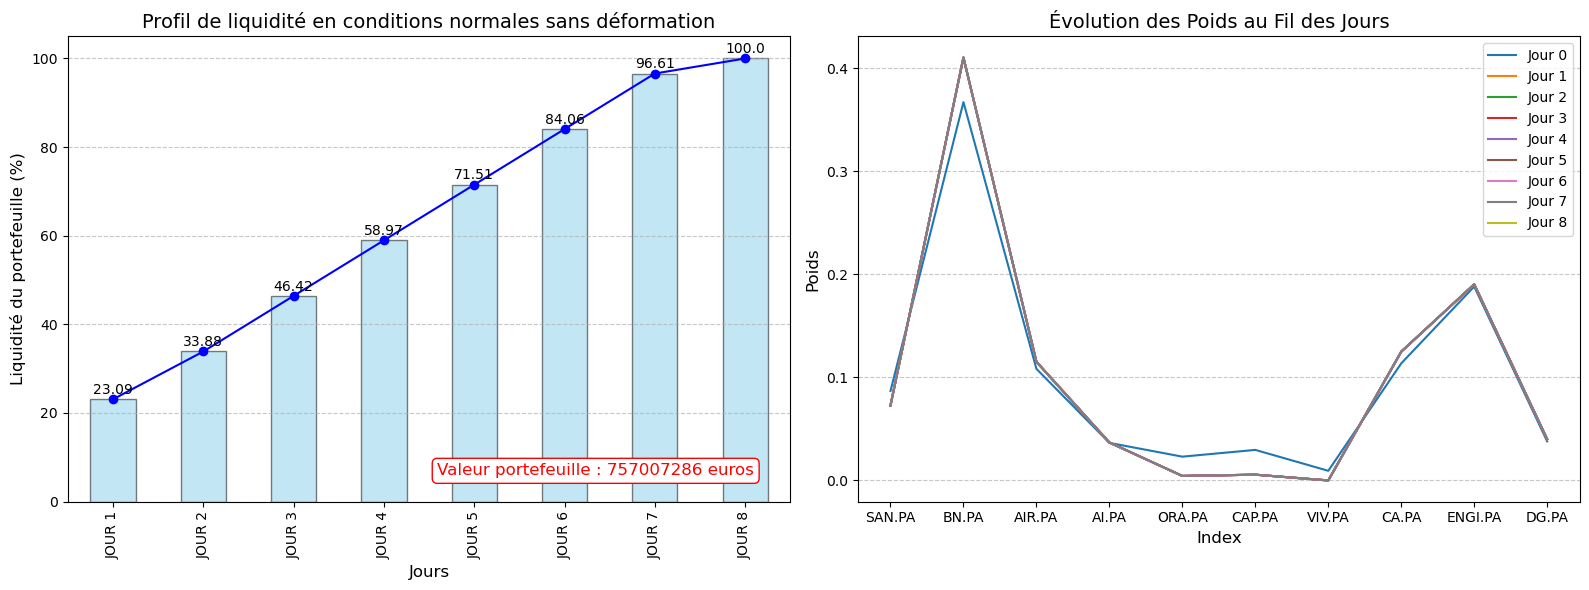

In [250]:
portfolio_liquidity = liqudity_proformat(df_volume)
liquidity_profile(portfolio_liquidity, label="Profil de liquidité en conditions normales sans déformation")

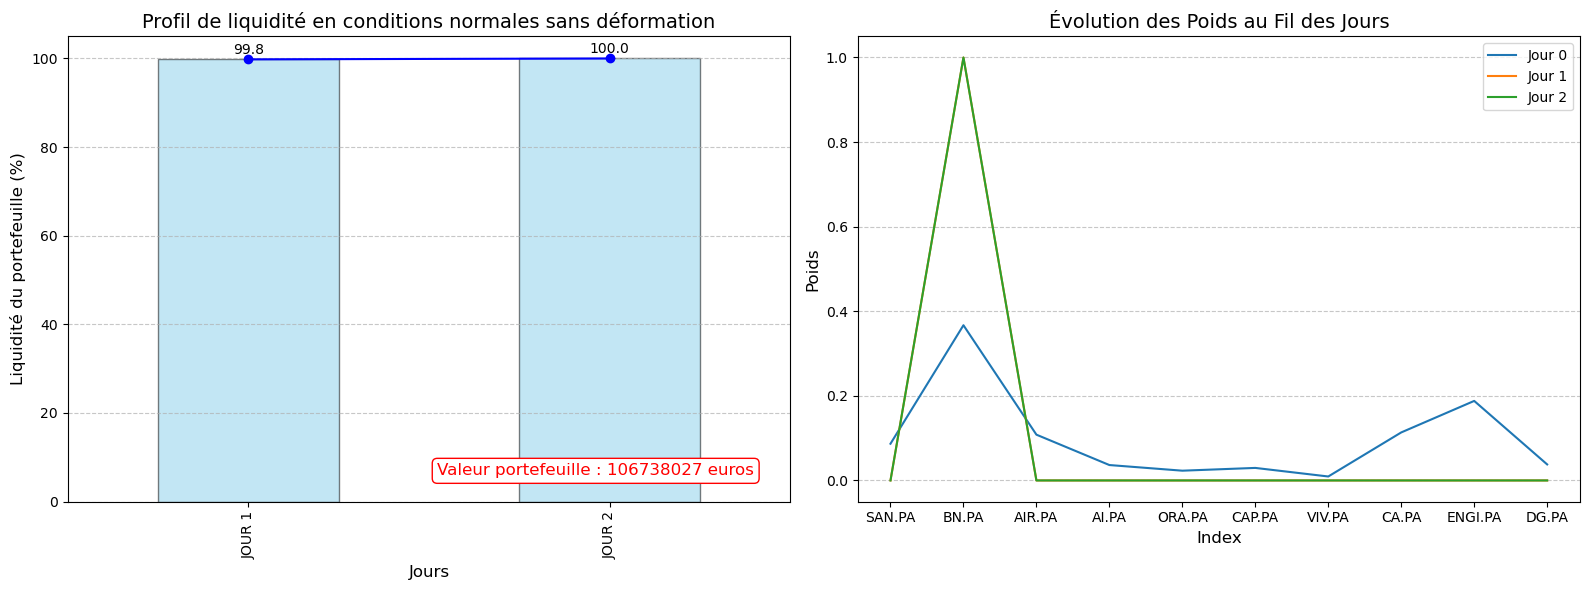

In [251]:
portfolio_liquidity = liqudity_proformat(df_volume, weight_adjust=0.141)
liquidity_profile(portfolio_liquidity, label="Profil de liquidité en conditions normales sans déformation")

## Profil de liquidité en conditions stressée sans déformation

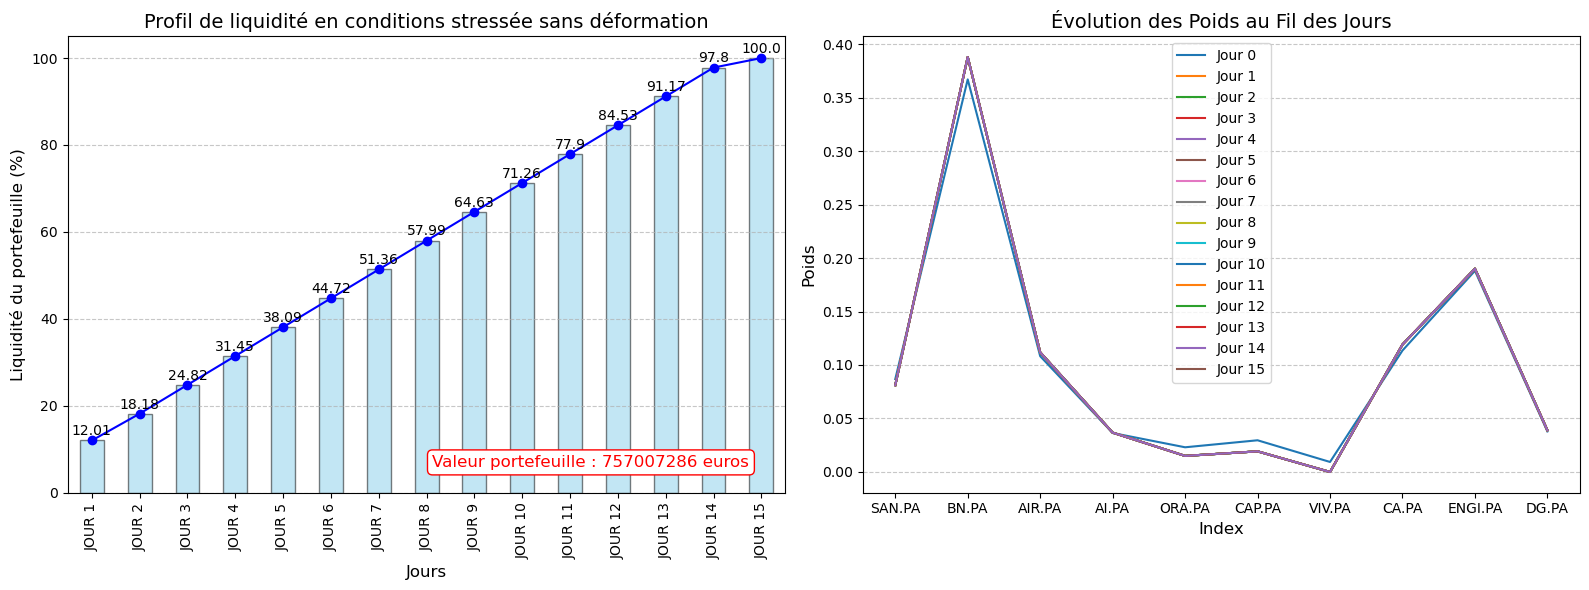

In [252]:
portfolio_liquidity = liqudity_proformat(df_volume, ADV_rate=0.1)
liquidity_profile(portfolio_liquidity, label="Profil de liquidité en conditions stressée sans déformation")

# Risque de crédit et risque de taux
---
- Dette côtée et 
- Dette non côtée

Le risque de crédit est sur le périmètre du retail.
Risque de gros doigt (e.g tapper un zero en trop, c'est un risque opérationnel).

Le taux d'intérêt: le loyer de l'argent (annualisé dans la pratique).
$$Loyer = taux \times annualisé \times période \times montant$$
---

De la métaphore du oyer à la métaphore du coffe-fort:
La métaphore du coffe-fort: garde la possibilité de passer à des taux d'intérêt négatifs. Cas d'une compagnie d' assura  nce qui est prêt à payer un taux d'intérêt négatif à un Etat pour garder son argent.

---
**Obligation**:
Obligation émises par les entreprises: Intermédiation entre a banque et les investisseurs (le marché). La banque collecte le nominal pour le compte de l'entreprise et reverse les annuité au marché. Elle se rémunèe via un commission. C'est l'entreprise qui honore les intérêts bien attendue.
Une obligation est, économiquement, un prêt-emprunt. 
Courbe de l'évolution du prix d'une obligation.

Valorisation d'un actif: Espérence des flux actualisés au taux sans risque sous la probabilité risque neutre.

\begin{align}
X_0 &= E[e^{-rT}X_T]
    &= e^{-rT}C\times PS 
\end{align}

**N.B**: *Taux de recouvrement historique est de 40%*. Le recouvrement s'applique uniquement au nominal.

---
La proba de survie est généralement déterminée à partir du modèle à intancité de Poisson via la relation
$$PS(T) = e^{-\lambda T}$$

Considérons une obligation d'échéances $T_i$, $i=1,...,n$, de coupon $c$ et de nominal $N$. Les coupons et le nominal sont payés en cas de survie et le ecouvrement en cas de défaut.

La valeur de cette obligation à la date t vaut:

\begin{align}
    C_t = \sum_{i=1}^{n} c \times e^{-(\lambda+r)(T_i-t)} \mathbf{1}_{T_i \geq t}
\end{align}

---
La proba de survenu du f=défaut à une date t vaut
\begin{align}
    PD_t(u) &= PS_t(u) - PS_t(u+du)
          &= - \frac{PS_t(u+du)- PS_t(u)}{du} du
          &= - \frac{dPS_t(u)}{du} du
          &= \lambda e^{-\lambda(u-t)}du
\end{align}

\begin{align}
    \mathcal{R}_0 &= \int_0^T R(\lambda e^{-\lambda t}) e^{-rt}dt
          &= \lambda R \frac{1 - e^{-(r+\lambda)T}}{r+\lambda}
\end{align}

\begin{align}
    \mathcal{R}_t &= \int_t^T R(\lambda e^{-\lambda (u-t)}) e^{-r(u-t)}du
          &= \lambda R  \frac{1 - e^{-(r+\lambda)(T-t)}}{r+\lambda} \mathbf{1}_{T \geq t}
\end{align}

\begin{align}
    B_t &= \sum_{i=1}^{n} c \times e^{-(\lambda+r)(T_i-t)} \mathbf{1}_{T_i \geq t} + \left(e^{-(r+\lambda)(T_n - t)} + \lambda R\frac{1 - e^{-(r+\lambda)(T_n-t)}}{r+\lambda} \right) \mathbf{1}_{T_n \geq t}
\end{align}

In [60]:
# Impementation de la fonctiuon de valorisation d'un bond
import numpy as np

def Bond(t,c,T,r,lamda, R = 0.4):
    B = 0
    for T_i in range(1,T+1):
        B += np.exp(-(lamda + r)*(T_i - t))*(T_i>=t)
    B *= c
    B += (np.exp(-(r + lamda)*(T_i-t)) + lamda * R * (1-np.exp(-(r + lamda)*(T_i-t))) / (r + lamda))*(T_i>=t)
    return B

In [61]:
# Exemple1: Obligation au pair
lamda = 0
r = 0.02
c = 0.02
t = 0
T = 10
Bond(t,c,T,r,lamda)

0.9981933497987289

Avec les paramètres ci-dessus considérés, on remarque que le prix de l'obligation est proche du nominal. En effet, le taux coupon est égale au taux de marché, ce qui indique que l'obligation est remunérée au taux du marché. Il s'agit donc d'une obligation au pair.

---
Etant donné les autres paramètres, on peut également calculer le coupon pour lequel l'obligation est au pair.

In [86]:
# Recherche du coupon  pour émettre une obligation au pair.
def dichot(t,T,r,lamda, P_MKT):
    c_inf = 1e-8
    c_sup = 1
    epsi = 1e-8
    c_moy = (c_inf + c_sup)/2
    error = c_sup - c_inf

    while error>epsi:
        p_hw = Bond(t,c_moy,T,r,lamda)
        if p_hw > P_MKT:
            c_sup = c_moy
        elif p_hw < P_MKT:
            c_inf = c_moy
        c_moy = (c_inf + c_sup)/2
        error = np.abs(c_sup - c_inf)

    return c_moy
    

In [87]:
# Exemple2: Taux coupon pour émettre une obligation au pair
lamda = 0.01
r = 0.02
t = 0
T = 10
dichot(t,T,r,lamda, P_MKT = 1)

0.026393926193952293

N.B: $\lambda$

In [64]:
# Exemple2: Taux coupon pour émettre une obligation au pair
lamda = 1000
r = 0.02
c = 0.03
t = 0
T = 10
Bond(t,c,T,r,lamda)

0.3999920001599968

Dans le cas ci-dessus, on considère une intensité de défaut très élevé, c'est-à-dire que l'émetteur fait rapidement défaut. Dans ce cas on constate que le prixx de l'obligation est égale au taux de recouvrement.

Text(0.5, 1.0, 'Evolution du prix plein coupon du Bond')

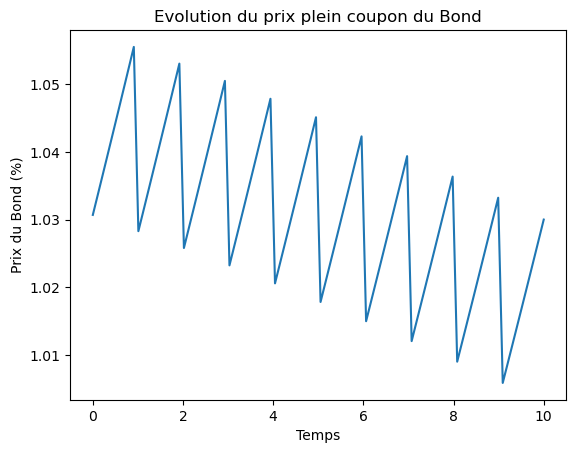

In [67]:
# Exemple2: Taux coupon pour émettre une obligation au pair
import matplotlib.pyplot as plt
lamda = 0.01
r = 0.02
c = 0.03
T = 10
times = np.linspace(0,10, num = 100)

B = np.array([Bond(t,c,T,r,lamda) for t in times])
plt.plot(times,B)
plt.xlabel("Temps")
plt.ylabel("Prix du Bond (%)")
plt.title("Evolution du prix plein coupon du Bond")

Chaque saut correspond à un détachement des coupon. C'est un prix plein coupon qui est polué par le coupon. Ces sauts ne reflètent pas une appréciation ou une dépréciation des bonds par le marché. Ce sont des sauts techniques.
En général, les prix plein coupon ne sont pas observés. Une manière de faire autrement consiste à considérer le Clean price qui correspond à un prix du bon moins le cpoupon couru.

\begin{align}
    \tilde{B}_t = B_t - cc
\end{align}
 où cc: coupon couru : 
 $$
    cc = c \times(t-T^*)
 $$
 Avec T^* est la partie entière de t.

In [95]:
# Implémentation du clean price

def CleanPrice(t,c,T,r,lamda, R = 0.4):
    cc = c*(t - np.floor(t))*(t<=T)
    return Bond(t,c,T,r,lamda, R)-cc

Text(0.5, 1.0, 'Evolution du prix du Bond')

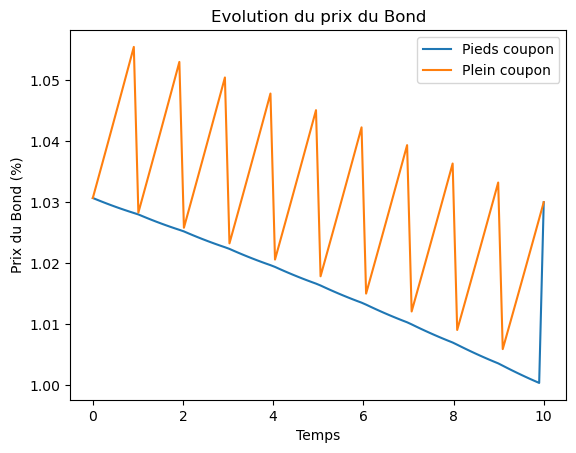

In [96]:
# Pieds coupon
lamda = 0.01
r = 0.02
c = 0.03
T = 10
times = np.linspace(0,10, num = 100)

B_plein_coupon = np.array([Bond(t,c,T,r,lamda) for t in times])
B_pieds_coupon = np.array([CleanPrice(t,c,T,r,lamda) for t in times])
plt.plot(times,B_pieds_coupon, label ="Pieds coupon")
plt.plot(times,B_plein_coupon, label ="Plein coupon")
plt.xlabel("Temps")
plt.ylabel("Prix du Bond (%)")
plt.legend()
plt.title("Evolution du prix du Bond")

A chaque date de coupon on retire l'effet du coupon courru afin d'avoir une evolution du prix continue.

Text(0.5, 1.0, 'Evolution du prix du Bond')

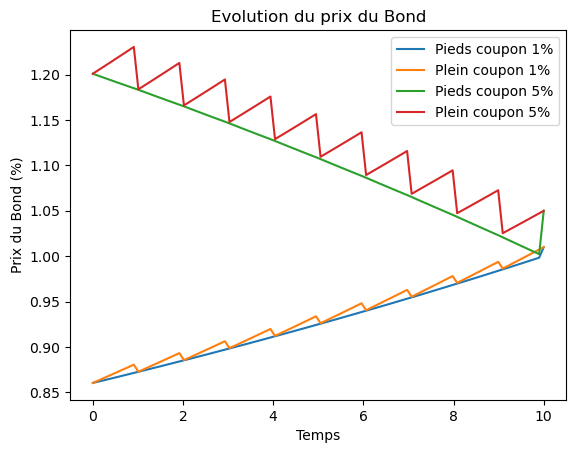

In [99]:
lamda = 0.01
r = 0.02
c = 0.01
T = 10

times = np.linspace(0,10, num = 100)
B_plein_coupon1 = np.array([Bond(t,0.01,T,r,lamda) for t in times])
B_pieds_coupon1 = np.array([CleanPrice(t,0.01,T,r,lamda) for t in times])

B_plein_coupon5 = np.array([Bond(t,0.05,T,r,lamda) for t in times])
B_pieds_coupon5 = np.array([CleanPrice(t,0.05,T,r,lamda) for t in times])

plt.plot(times,B_pieds_coupon1, label ="Pieds coupon 1%")
plt.plot(times,B_plein_coupon1, label ="Plein coupon 1%")

plt.plot(times,B_pieds_coupon5, label ="Pieds coupon 5%")
plt.plot(times,B_plein_coupon5, label ="Plein coupon 5%")
plt.xlabel("Temps")
plt.ylabel("Prix du Bond (%)")
plt.legend()
plt.title("Evolution du prix du Bond")

- L'obligation de coupon 1%, qui remunère moins que le taux de marché, est en dessous du pair et s'apprécie au cours du temps. A la veille il y a moins d'incertitude sur le prix. On obtiendra le nominal plus le coupon.
  
- Avec un coupon de 5%, l'obligation remunère davantage que le marché. L'attractivité de ce bond s'estompe à mesure qu'on s'avance de la maturité où sa valeur ne correspond plus qu'au nominal augmenté du dernier coupon.

C'est un modèle simplifié car on ne prend pas en compte la structure par terme des taux d'intérêt ou des intansité de saut.

## Evolution du prix de l'obligation en fonction du taux d'intérêt
---
De l'expression analytique du prix du bond, on observe que le prix est décroissant du taux d'intérêt. La figure ci-dessous en donne une illustration, toute chose égale par ailleurs.

Text(0.5, 1.0, "Evolution du prix du Bond en fonction du taux d'intérêt")

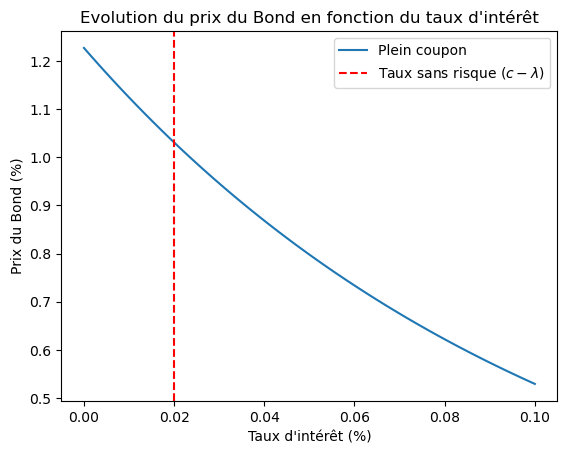

In [107]:
# Evolution du prix du bond en fonction du taux d'intérêt
lamda = 0.01
r = 0.02
c = 0.03
T = 10
interest = np.linspace(0,0.10, num = 100)

B_plein_coupon = np.array([Bond(t,c,T,r,lamda) for r in interest])

plt.plot(interest,B_plein_coupon, label ="Plein coupon")
plt.axvline(x=c-lamda, color='red', linestyle='--', label='Taux sans risque ($c- \lambda$)')
plt.xlabel("Taux d'intérêt (%)")
plt.ylabel("Prix du Bond (%)")
plt.legend()
plt.title("Evolution du prix du Bond en fonction du taux d'intérêt")

Le bond est au pair lorsque le taux vaut c - lambda.
Le coût d'opportunuité: investir sans risque à r

In [112]:
# Sensibilité du prix du bond
delta_r = 1e-4 #1bp


def Sensi(t,c,T,r,lamda, R = 0.4, delta_r = 1e-4):
    B_t = Bond(t,c,T,r,lamda, R)
    return -(Bond(t,c,T,r+delta_r,lamda, R)-B_t)/(delta_r*B_t)

In [ ]:
# Sensibilité au tau d'intérêt
Sensi(t,c,T,r,lamda, R = 0.4, delta_r = 1e-4)

8.643982489105056

Text(0.5, 1.0, "Evolution du prix du Bond en fonction du taux d'intérêt")

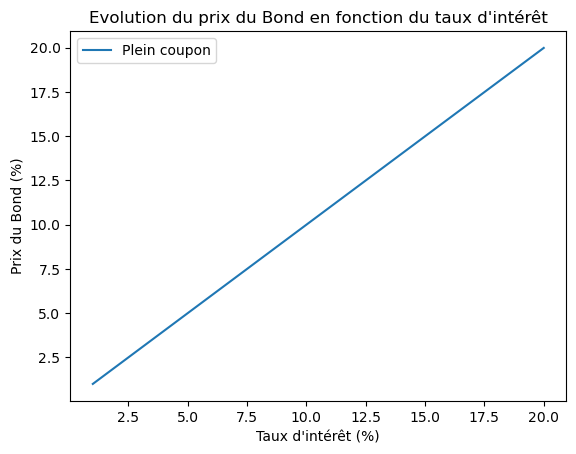

In [ ]:
# Valeur extrême de la sensibilité (egale à la maturité)
maturity = range(1,21)
censi = np.array([Sensi(t,1e-6,T,1e-6,1e-6) for T in maturity])

plt.plot(maturity, censi, label ="Plein coupon")
plt.xlabel("Taux d'intérêt (%)")
plt.ylabel("Prix du Bond (%)")
plt.legend()
plt.title("Evolution du prix du Bond en fonction du taux d'intérêt")